In [168]:
from matplotlib import pyplot as plt
import numpy as np

from numpy import random, nan
from scipy import stats
from scipy.fft import fft2, ifft2
from scipy import stats
import skimage.feature as skimf
from sklearn.mixture import GaussianMixture
from sklearn.svm import SVC, NuSVC

from astropy.io import fits

from copy import copy, deepcopy

In [2]:
def two_blobs(size=(300, 300)):
             
    all_indices = np.indices(size)
    x_scales = all_indices[0] / size[0]
    y_scales = all_indices[1] / size[1] # are x and y the correctly matched?? 
             
    mu_xes = 0.5 - 0.2 * y_scales; sigma_x = 0.12
    mu_y = 0.5; sigma_y = 0.2
    image = np.exp(-0.5 * ((x_scales - mu_xes)/ sigma_x)**2) * np.exp(-0.5 * ((y_scales - mu_y)/ sigma_y)**2)
    
    mu_xes_2 = 0.9 - 0.15 * y_scales; sigma_x_2 = 0.04
    mu_y_2 = 0.7; sigma_y_2 = 0.03
    image += np.exp(-0.5 * ((x_scales - mu_xes_2)/ sigma_x_2)**2) * np.exp(-0.5 * ((y_scales - mu_y_2)/ sigma_y_2)**2) 
    
    return image

In [31]:
frodo = two_blobs(size=(300, 300))
print(isinstance(frodo, np.ndarray))
print(np.shape(frodo))

True
(300, 300)


(300, 300)
set_image(): image is set 
()
len(nan_inds) =  0
len(non_nan_inds) =  90000
forward_trafo(): fft is done
forward_trafo(): angles and radii are calculated
hard_threshold:  2000  strongest components will be selected.
hard_threshold(): final threshold is  14072.240418337355
backward_trafo(): operating on roughly preselected radii
backward_trafo(): image has been retransformed from fourier-space


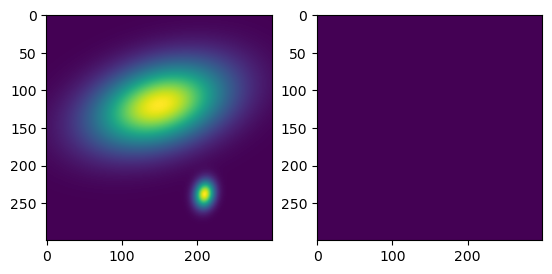

In [172]:

# next time: declare the class in one file and then write the functions in another, like the pros do. 

class single_image_denoising:
    # data to be stored in the class
    image = None
    masked_image = None
    denoised_image = None
    
    mask_ready = False
    
    fft_image = None
    abs_fft_image = None
    ang_fft_image = None # DO I EVEN have to calculate these angles??
    
    fft_to_be_retransformed = None
    # if a full image is to be retransformed, let us make a new variable for it!
    # fft_to_be_retransformed = None
    retransformed_image = None
    
    preselected_fft_comps = None # should be complex numbers, please.
    preselected_fft_comps_indices = None # these should be indices
    
    final_fft_comps = None # should be complex numbers, please.
    final_fft_comps_indices = None  # these should be indices
    
    im_fits_header = None
    
    # methods for reading in images
    def __init__(self, image:np.array=None, path:str=None, masked=False):
        
        if image is not None: 
            set_image(image, masked=masked, func_name='__init__()')
        elif path is not None:
            load_image(path, masked=masked, func_name='__init__()')
    
    def set_image(self, image:str, masked=False, func_name='set_image()'): 
        if isinstance(image, np.ndarray) is True: 
            if len(np.shape(image)) in [2, 3]:
                if masked is False:
                    self.image = image
                elif masked is True:
                    self.masked_image = image
                    self.mask_ready = True # indent end       
            else:
                print("fft_denoising: " + func_name +  ": image has the wrong dimensions. Array must be of dimension 2 or 3.")
        else: 
            print("fft_denoising: " + func_name +  ": image should be a numpy array of dimension 2 or 3.")
        print('set_image(): image is set ')
        
    def load_image(self, path:str, masked=False, func_name='load_image()'):
        lenpa = len(path)
        if '.fits' == path[lenpa-5:lenpa]:
            hdu_image = fits.open(path)
            if masked is False:
                self.image = hdu_image[0].data
            elif masked is True:
                self.masked_image = hdu_image[0].data
                self.mask_ready = True # indent ends
                self.im_fits_header = hdu_image[0].header
        else: 
            print("fft_denoising: " + func_name + ": I want a .fits image.")
            
        print('set_image(): image is loaded ')
    
        
    # methods for doing the fft. Always use finufft, since it works. 
    
    def forward_trafo(self, mode='random', distribution='gamma', scipy_distribution=None, rng=777, fit_bounds=None, fit_params=None, radio_safety=False): # maybe we can add a planner later, for more performance
        # Am I wasting memory by declaring to_transform separately? 
        # probably not, since there has to be an array on which the FFT is performed
        # at some point
        if self.mask_ready is True:
            # if image was masked with functions from this class: work on self.masked_image
            to_transform = self.masked_image      
        else: 
            # if image was masked before, or did not need a mask: work on self.image
            to_transform = self.image 
            
        image_type = type(to_transform[0])
        nan_inds = np.argwhere(np.isnan(to_transform) == True)
        non_nan_inds = np.argwhere(np.isnan(to_transform) == False)
        print('len(nan_inds) = ', len(nan_inds))
        print('len(non_nan_inds) = ', len(non_nan_inds))
        
        # Various methods to deal with holes (nan-s) in the image
        if mode == 'zero':
            # set all nans to zero and stupidly transform them.
            # might yield artefacts if there were many holes / nans
            np.put(to_transform, nan_inds, np.zeros(len(nan_inds), dtype=image_type))
            # FINALLY; THE TRANSFORM!!!
            self.fft_image = fft2(to_transform)
            
        elif mode == 'random':
            print('forward_trafo: mode is random')
            # fill holes / nans with random numbers matching the rest of the image
            # fit the distribution on the non-nans 
            # AND make the non-nans 1D so that the fit works out
            image_subset = np.ravel(to_transform[non_nan_inds])
            im_sub_std = np.std(image_subset); im_sub_mean = np.mean(image_subset)
            # the minimum is needed for the emergency case, in which we fit a 
            # truncated normal distribution
            im_sub_min = np.min(image_subset); im_sub_max = np.max(image_subset)
            print('Mean of image subset = ', im_sub_mean, " std = ", im_sub_std)
            
            # image_subset = to_transform
            image_subset /= im_sub_std 
            
            if fit_bounds is not None: 
                print('forward_trafo(): YOU are responsible to provide proper bounds for your statistical distribution of choice!')
                bounds = fit_bounds
                
            # is a poisson-distribution the best??
            if distribution == 'poisson':
                print('forward_trafo: noise distribution is Poisson')
                # fit a poisson # can we determine the parameters quicker??
                # only one parameter: expected value for the pixel intensity lambda
                # lambda must be positive.
                dist = stats.poisson
                # Does the standard deviation trick work for poisson distributions?
                if fit_bounds is None: bounds = [(0.0, im_sub_max / im_sub_std)]

            elif distribution == 'gamma':
                print('forward_trafo: noise distribution is Gamma')
                # shape and rate parameters: a and b.
                # two bounds are needed
                # calculate a and b from mean and standard deviation of the new image subset!!!
                # mean = alpha / beta; std = sqrt( alpha / beta^2 )
                dist = stats.gamma
                # Do I even need the fit??
                if fit_bounds is None: bounds = [(0.0, 10.0), (0.0, 10.0)]
                print('forward_trafo: noise distribution is still Gamma')
                    
            elif distribution == 'rice':
                print('forward_trafo: noise distribution is Gamma')
                # only one parameter: shape-parameter b or v
                # it is smaller than the mean of the distribution, usually.
                dist = stats.rice
                if fit_bounds is None: bounds = [(0.0, im_sub_mean * 3.0)]
                    
            elif scipy_distribution is not None:
                dist = scipy_distribution
                bounds = fit_bounds
                print('forward_trafo(): manually set distribution must be from scipy.stats. fit_bounds must be proper bounds.')
            
            # do the fit!
            print('It goes til here')
            print('DIST ', dist)
            print('\n IMAGE_SUBSET ', np.max(image_subset), np.min(image_subset), len(image_subset))
            print('\n BOUNDS ', bounds)
            if fit_params is None: res = stats.fit(dist, image_subset, bounds)
            print('Also til here?')
            # check the result of the fit procedure
            print('forward_trafo(): success of fit is ', res.success)
            if fit_params is not None: params = fit_params
            else:
                if res.success is True: params = res.params
                else: fit_problems == True
            print('forward_trafo(): fit is done.')
            
            # if nothing works, get your random numbers just from standard deviation 
            # and mean of the image.
            # MAYBE ADD A GAMMA DISTRIBUTION LATER. JUST FOR FUN.
            if distribution == 'super_primitive' or fit_problems is True:
                loc = im_sub_mean; scale = im_sub_std
                # the super-safe way. Should always work.
                a_trunc = im_sub_min; b_trunc = im_sub_max
                if radio_safety is True:
                    # for only slightly asymmetric data, like radio, do it like that:
                    a_trunc = 0.0; b_trunc = im_sub_std * 3.0 + im_sub_mean; 
                
                loc = im_sub_mean; scale = im_sub_std
                a, b = (a_trunc - loc) / scale; (b_trunc - loc) / scale
                
                dist = stats.truncnorm(a, b, loc=loc, scale=scale)
                random_filler = dist.rvs(size=len(nan_inds), random_state=rng)
            else:
                random_filler = im_sub_std * dist.rvs(params, size=len(nan_inds), random_state=rng)
            
            print('forward_trafo(): super-primitive fit is done.')
            # fill the random numbers into the image array at the right places
            np.put(to_transform, nan_inds, random_filler)
            # FINALLY; THE TRANSFORM!!!
            self.fft_image = fft2(to_transform)
            
        elif mode == 'nudft':
            # do a proper non-uniform discrete fourier transform
            # with Julia, sometime.
            pass
        
        print('forward_trafo(): fft is done')
        # save absolute values and angles. you can cut them in half, if you want. Maybe later.
        self.abs_fft_image = np.abs(self.fft_image)
        self.ang_fft_image = np.angle(self.fft_image)
        print('forward_trafo(): angles and radii are calculated')
        
    def backward_trafo(self):
        # check which information is there and accordingly, put together 
        # self.fft_to_be_retransformed
        self.fft_to_be_retransformed = self.fft_image
        
        if self.final_fft_comps_indices is not None:
            print('backward_trafo(): operating on fitted radii')
            # calculate the right numbers to put into the array
            self.fft_to_be_retransformed *= 0.0 # multiplying by zero is very important!
            np.put(self.fft_to_be_retransformed, self.final_fft_comps_indices, self.final_fft_comps)
            
        elif self.preselected_fft_comps_indices is not None:
            print('backward_trafo(): operating on roughly preselected radii')
            np.put(self.fft_to_be_retransformed, self.preselected_fft_comps_indices, self.preselected_fft_comps)
            self.fft_to_be_retransformed *= 0.0 # multiplying by zero is very important!
        else:
            # re transform the original image
            pass
            print('backward_trafo(): operating in test mode. Just re-transforming the image.')
            
            
        self.retransformed_image = ifft2(self.fft_to_be_retransformed)
        print('backward_trafo(): image has been retransformed from fourier-space')
    
    
    # methods for choosing the right fourier coefficients
    def hard_threshold(self, fit_thres:float=0.99, hard_thres:float=None, sigma_0:float=4.0, number_thres=None):
        if fit_thres >= 1.0:
            print('hard_thres: keyword arg fit_thres must be smaller than 1.0. It refers to the mass of a probability distribution.')
            fit_thres = 0.99
            print('hard_thres: fit_thres is automatically set to ', fit_thres)
        # take only the points which are above some Gaussian threshold 
        mean_abs_fft_image = np.mean(self.abs_fft_image)
        std_abs_fft_image = np.std(self.abs_fft_image)
        sig_cut_for_fitting =  mean_abs_fft_image + std_abs_fft_image * sigma_0 # is always positive
        indices_for_fitting = np.where(self.abs_fft_image >= sig_cut_for_fitting) # bigger of bigger and equal?
        # ATTENTION! Fit values are divided by the std, so that the fitting procedure works more reliably.
        # MULTIPLY the std later with the threshold!!!
        values_for_fitting = self.abs_fft_image[indices_for_fitting] / std_abs_fft_image
        
        if number_thres is not None:
        # select the number_thres strongest components in the spectrum
            N = int(np.round(number_thres))
            print('hard_threshold: ', N, ' strongest components will be selected.')
            sorted_out = np.sort(np.ravel(self.abs_fft_image))
            final_thres = np.max(sorted_out)
            counter = 0
            for ind in range(np.size(sorted_out), 0):
                if counter > number_thres:
                    final_thres = sorted_out[ind-1]
                    
                counter += 1
            
        elif hard_thres is not None: 
        # fit a distribution to them # do not forget the boundaries!
            final_thres = mean_abs_fft_image + hard_thres * std_abs_fft_image
            print('hard_threshold: simple threshold from standard deviation')
        else:
            gamma_bounds = [(0, 10), (0, 10)]
            gamma_fit = stats.fit(stats.gamma, values_for_fitting, gamma_bounds)
            print('hard_threshold: I will fit a gamma distribution ;-)')

            if gamma_fit.success is True: 
                gamma_fit_params = gamma_fit.params
                a_gf = gamma_fit_params[0]; loc_gf = gamma_fit_params[1]; scale_gf = gamma_fit_params[2]

                # get the position where the gamma function has left specific probability to the left. ---> CDF()
                # percent point function is the inverse of the CDF! .ppf(ppf(q, a, loc=0, scale=1))
                gamma_thres = stats.gamma.ppf(a_gf, fit_thres, loc=loc_gf, scale=scale_gf) # fit_thres is the argument
                final_thres = gamma_thres * std_abs_fft_image

            else: # do a more primitive way of setting the threshold.
                final_thres = mean_abs_fft_image + hard_thres * std_abs_fft_image
        
            # fit another one cause its cool!
            skew_exp_bounds = [(0, 10), (0, 10)]
            skew_exp_fit = stats.fit(stats.gamma, values_for_fitting, gamma_bounds)

        # get the threshold, somehow with integral thinking...
        print('hard_threshold(): final threshold is ', final_thres)
        # make a smart cut which always works and is indicated by kw 'thres'

        # fit another distribution
        
        # smaller-or-equal is important for setting a number threshold
        self.preselected_fft_comps_indices = np.argwhere(self.abs_fft_image > final_thres)
        # ATTENTION! This is only sufficient if fit absolute values, and nothing more. Otherwise write down valu
        self.preselected_fft_comps = self.fft_image[self.preselected_fft_comps_indices]

    def soft_thres(self, thres=1.3):
        pass

    def fit_SVC(self):
        pass 

    def fit_sbi(self):
        pass
    # they should have return values, so be callable from outside for other programmers
    
    # methods for actually doing the denoising operation
    
    # just for one image...
    
    # or hierarchical
    
    # mask the image, if necessary. I.e. take out all the islands with pybdsf or so.
    def mask_point_sources(self):
        # mask_ready decides which image to use for FFT.
        self.mask_ready = True
        
    def mask_image(self, index_array:np.array):
        # apply the mask to the image
        if np.size(index_array) != np.size(image): 
            print('\nSizes of mask and image do not match up. Image dimensions are ', size(image))
            
        self.masked_image = self.image * index_array
        # mask_ready decides which image to use for FFT.
        self.mask_ready = True
        
print(np.shape(frodo))
my_bro = single_image_denoising()
my_bro.set_image(frodo, masked=False)

print(np.shape(my_bro.masked_image))
my_bro.forward_trafo(mode='zero')
my_bro.hard_threshold(number_thres=2000)
my_bro.backward_trafo()

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(frodo)
ax2.imshow(np.abs(my_bro.retransformed_image))

In [170]:
print(np.shape(my_bro.preselected_fft_comps_indices))
print(np.size(my_bro.preselected_fft_comps_indices))
print(np.shape(my_bro.preselected_fft_comps))
print(np.size(my_bro.preselected_fft_comps))



(0, 2)
0
(0, 2, 300)
0


image = None
    masked_image = None
    denoised_image = None
    
    mask_ready = False
    
    fft_image = None
    abs_fft_image = None
    ang_fft_image = None # DO I EVEN have to calculate these angles??
    
    fft_to_be_retransformed = None
    # if a full image is to be retransformed, let us make a new variable for it!
    # fft_to_be_retransformed = None
    retransformed_image = None
    
    preselected_fft_comps = None # should be complex numbers, please.
    preselected_fft_comps_indices = None # these should be indices
    
    final_fft_comps = None # should be complex numbers, please.
    final_fft_comps_indices = None  # these should be indices

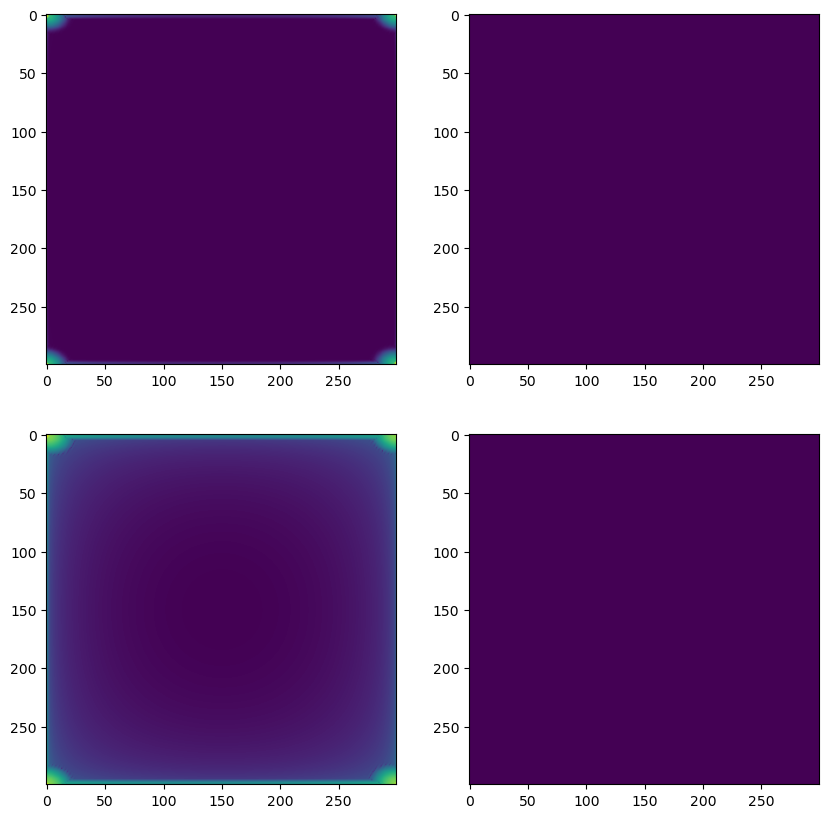

In [171]:
fig, (ax) = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].imshow(np.log(np.abs(my_bro.fft_image) + 1.0)); ax[0, 1].imshow(np.log(np.abs(my_bro.fft_to_be_retransformed) + 1))
ax[1, 0].imshow(np.log(my_bro.abs_fft_image) + 1.0); sandro = my_bro.fft_image * 0.0
sandro[my_bro.preselected_fft_comps_indices] = my_bro.preselected_fft_comps
ax[1, 1].imshow(np.log(np.abs(sandro) + 1))

In [165]:
sandro

array([[ 0.+0.j, -0.+0.j,  0.+0.j, ...,  0.+0.j, -0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j, ..., -0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j, ...,  0.+0.j,  0.+0.j,  0.+0.j],
       ...,
       [-0.+0.j,  0.+0.j,  0.+0.j, ..., -0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j, ...,  0.+0.j,  0.+0.j, -0.+0.j],
       [-0.+0.j,  0.+0.j, -0.+0.j, ...,  0.+0.j, -0.+0.j,  0.+0.j]])

In [25]:
dist = stats.gamma
data = np.ravel(frodo / np.std(frodo)) # np.abs(np.random.normal(10, size=1000) + 10.0)
stats.fit(dist, data, bounds=[(0, 10), (0, 10)])

  params: FitParams(a=0.38545704788767754, loc=9.335303197133271e-09, scale=1.0)
 success: True
 message: 'Optimization terminated successfully.'

In [80]:
np.sort(data, order=-1)

ValueError: Cannot specify order when the array has no fields.

In [ ]:
# cut the upper half
upper = half[0:hx, :]
lower = half[hx:, :]
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(np.log(upper))
ax2.imshow(np.log(lower))

In [ ]:
upper_2 = np.rot90(np.rot90(upper))
lower_2 = np.rot90(np.rot90(lower))
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(np.log(upper_2[0:10, 0:10]))
ax2.imshow(np.log(lower_2[140:, 0:10]))

In [ ]:
plt.imshow(np.log(my_bro.abs_fft_image)[140:160, 140:160])

In [ ]:
erongo = np.log(np.abs(fft2(frodo)))
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(erongo[0:10, 0:10])
ax2.imshow(erongo[280:np.shape(erongo)[0], 0:10])

In [ ]:
erongo = np.log(np.abs(fft2(frodo)))
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(erongo)
ax2.imshow(np.log(everything))

In [ ]:
retrafo = flip_to_scipy_format(my_bro.fft_image)
bilbo = np.abs(ifft2(retrafo))

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(frodo)
ax2.imshow(bilbo)

In [ ]:
gamma_bounds = [(0, 10), (0, 10)]
gamma_fit = stats.fit(stats.gamma, np.abs(np.random.normal(size = 1000)), gamma_bounds)
gamma_fit.params

In [ ]:
np.abs(np.random.normal(size=1000))

In [ ]:
omg = 'omg.fits'

In [ ]:
leno = len(omg)
omg[leno-5:leno]

In [ ]:
allo = np.nan
np.isnan(allo)

In [ ]:
np.indices((10,10))

In [ ]:
import asciitable
import pandas as pd

In [ ]:
ned = asciitable.read('/Users/leonard/RadioAstro/data/ned_pp_redshift_cat.txt')


In [ ]:
ned_keys = ['No.', 'Object Name', 'RA', 'DEC', 'Type', 'Velocity', 'Redshift', 'Redshift Flag', 'Magnitude and Filter', 'Separation', 'References', 'Notes', 'Photometry Points', 'Positions', 'Redshift Points', 'Diameter Points', 'Associations']
ned['No.']

In [ ]:
# build a pandas dataframe out of it
ned_indices = ned['No.']

d = {
    'No.': pd.Series(ned_indices, ned_indices)
}
ned_df = pd.DataFrame(d)

for key in ned_keys:
    if key == 'No.':
        continue
        
    data = ned[key]
    pds = pd.Series(data, ned_indices)
    
    new_dict = {
        key: pds
    }
    
    new_df = pd.DataFrame(new_dict)
    
    ned_df = pd.concat([ned_df, new_df], axis=1)
    

In [ ]:

ned_df.to_csv('ned_pp_redshift_cat_pandas.csv')
ned_df

In [ ]:
names = ['Designation', 'ra', 'dec', 'l', 'b', 'K2M++', 'Vh',  'Vcmb',  'Verr', 'GID', 'c11.5', 'c12.5', 'ZoA', 'Cln.', 'M0',  'M1', 'M2', 'Bibcode']
second_names = ('Designation', 'ra', 'dec', 'l', 'b', 'K2M++', 'Vh',  'Vcmb',  'Verr', 'GID', 'c11.5', 'c12.5', 'ZoA', 'Cln.', 'M0',  'M1', 'M2', 'Bibcode')
print(names)
tmpp = asciitable.read('/Users/leonard/RadioAstro/data/2M++/2M++.txt', names=names)

In [ ]:
print(tmpp['ra'])

In [ ]:
from astropy.table import Table
less_names = ['Designation', 'ra', 'dec', 'K2M++', 'Vh', 'ZoA']
new_table = Table([tmpp['Designation'], tmpp['ra'], tmpp['dec'], tmpp['K2M++'], tmpp['Vh'], tmpp['ZoA']], names=less_names)

In [ ]:
new_table.write('ned_pp_smaller.txt', format='ascii')

In [ ]:
from astropy.coordinates import SkyCoord
c = SkyCoord(28.0, 34.0, frame='icrs', unit='deg')
c2 = SkyCoord(33.0, 39.0, frame='icrs', unit='deg')
c3 = SkyCoord(23.0, 29.0, frame='icrs', unit='deg')

In [ ]:
c.to_string('hmsdms')

In [ ]:
c2.to_string('hmsdms')

In [ ]:
c3.to_string('hmsdms')

In [69]:
np.size(np.zeros((10, 10)))

100